In [1]:
import geopandas as gpd
import fiona
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import momepy
import libpysal
import osmnx
import pandas
from bokeh.io import output_notebook
from bokeh.plotting import show
from clustergram import Clustergram
from shapely.geometry import Point

output_notebook()

c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

In [2]:
root_folder = "/Users/david/Desktop/DSSG/Michaels_Data/All_Layers"
# List all .gdb directories in the folder
gdb_files = []
for dirpath, dirnames, filenames in os.walk(root_folder):
    # Check if the folder contains a "commondata" folder
    if "commondata" in dirnames:
        commondata_folder = os.path.join(dirpath, "commondata")
        commondata_folder = os.path.normpath(commondata_folder)

        # List all .gdb files in the "commondata" folder
        for f in os.listdir(commondata_folder):
            if f.endswith('.gdb'):
                gdb_files.append(os.path.join(commondata_folder, f))

# Print the collected .gdb files
for gdb in gdb_files:
    print(gdb)
print("GDB Files:", gdb_files)

\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\commondata\myproject16.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\commondata\scratch.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\חלקות\commondata\myproject16.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\חלקות\commondata\scratch.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\מרקמים\commondata\myproject16.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\מרקמים\commondata\scratch.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\קונטור בניינים\commondata\jps_reka.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\קונטור בניינים\commondata\scratch.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\רגישות\commondata\myproject16.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\קונטור בניינים\commondata\scratch.gdb
\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\רגישות\commondata\myproject16.gdb
GDB Files: ['\\Us

In [3]:
place = "Jerusalem, Israel"
local_crs = "EPSG:2039"

# Geocode using Nominatim
# latitude = 31.7683
# longitude = 35.2137
# point = gpd.GeoDataFrame(geometry=[Point(longitude, latitude)], crs="EPSG:4326")

#Load open street buildings
osm_buildings = osmnx.features_from_place(place, tags={"building": True})
osm_buildings = osm_buildings[osm_buildings.geom_type == "Polygon"].reset_index(drop=True)
osm_buildings = osm_buildings[["geometry"]].to_crs(local_crs)
osm_buildings.head()
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

# load open street streets
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)
streets.head()
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]

In [4]:
# load municipal buildings
gdb_file = gdb_files[6]  # Modify if you want to choose a different .gdb
print(gdb_file)
# List the layers in the selected .gdb
layers = fiona.listlayers(gdb_file)
print("Layers in the selected GDB:", layers)

# Choose a specific layer within the .gdb
textures_layer = layers[0]  # Modify if you want to choose a different layer

# Load the specific layer
gdf = gpd.read_file(gdb_file, layer=textures_layer)
m_buildings = gdf[["geometry"]]
m_buildings = m_buildings.to_crs(osm_buildings.crs)

\Users\david\Desktop\DSSG\Michaels_Data\All_Layers\מרקמים\קונטור בניינים\commondata\jps_reka.gdb
Layers in the selected GDB: ['buildings']


c:\Users\david\Desktop\DSSG\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


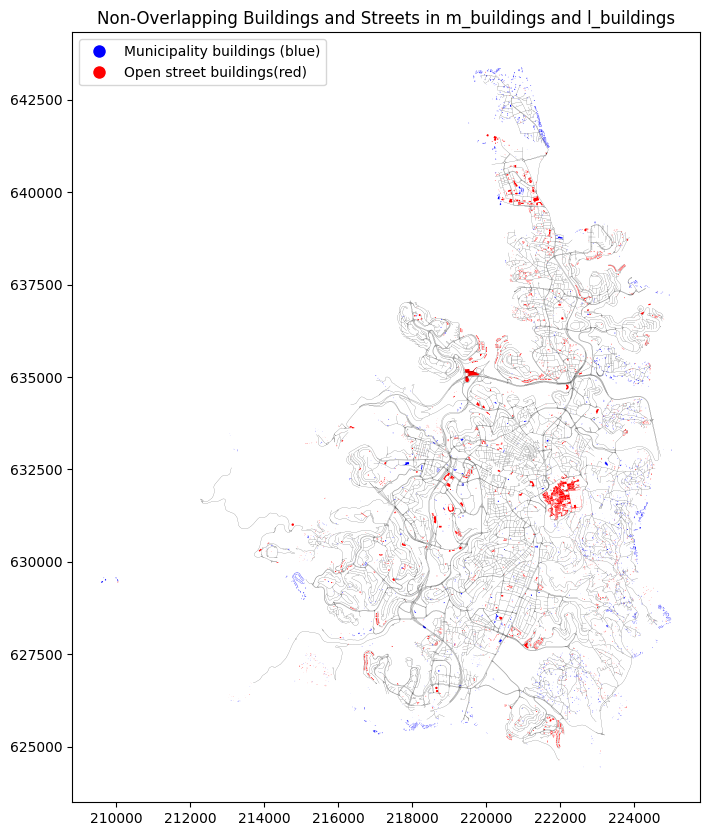

In [5]:
# Perform a spatial join to find overlaps between m_buildings and l_buildings
overlapping_buildings = gpd.sjoin(m_buildings, osm_buildings, how="inner", op="intersects")

# Find buildings in m_buildings that do not overlap with any building in l_buildings
non_overlapping_m_buildings = m_buildings[~m_buildings.index.isin(overlapping_buildings.index)]

# Find buildings in l_buildings that do not overlap with any building in m_buildings
non_overlapping_l_buildings = osm_buildings[~osm_buildings.index.isin(overlapping_buildings['index_right'])]

# Plot the non-overlapping buildings along with streets
fig, ax = plt.subplots(figsize=(10, 10))

# Plot non-overlapping buildings from m_buildings (blue), if they exist
if not non_overlapping_m_buildings.empty:
    non_overlapping_m_buildings.plot(ax=ax, color='blue', label='Non-overlapping m_buildings', alpha=1)

# Plot non-overlapping buildings from l_buildings (red), if they exist
if not non_overlapping_l_buildings.empty:
    non_overlapping_l_buildings.plot(ax=ax, color='red', label='Non-overlapping l_buildings', alpha=1)

# Plot narrow streets (black with red edges), if they exist


streets.plot(ax=ax, color='black', linewidth=0.1)

# Manually handle the legend to ensure it only appears when layers are present
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Municipality buildings (blue)',
                          markerfacecolor='blue', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Open street buildings(red)',
                          markerfacecolor='red', markersize=10)]

# Add the custom legend to the plot
ax.legend(handles=legend_elements, loc='upper left')

# Add title and show plot
plt.title("Non-Overlapping Buildings and Streets in m_buildings and l_buildings")
plt.show()